In [1]:
import glob
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy
import re
import os
import pandas as pd
import pywt
from scipy.fftpack import fft
from warnings import warn
from sklearn import metrics

import warnings 
warnings.filterwarnings('ignore')

In [2]:
num_samples = 1200 # Length of input segment
###########################################
fs = 12000; # Sampling freq.

In [3]:
def apply_fft(x, fs, num_samples):
    f = np.linspace(0.0, (fs/2.0), num_samples//2)
    freq_values = fft(x)
    freq_values = 2.0/num_samples * np.abs(freq_values[0:num_samples//2])
    return f, freq_values

In [4]:
def make_dataset(data_src, num_samples, class_):
    
    req_key = "_DE_time"
    pattern = re.compile(req_key)
    files = glob.glob(data_src)
    files = np.sort(files)
    data = loadmat(files[0])
    keysList = [key for key in data]
    for key in keysList:
        if pattern.search(key):
            my_key = key
    drive_end_data = data[my_key]
    drive_end_data = drive_end_data.reshape(-1)
    num_segments = np.floor(len(drive_end_data)/num_samples)
    slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
    silces = np.array(slices).reshape(int(num_segments), num_samples)
    segmented_data = silces
    files = files[1:]
    for file in files:
        data = loadmat(file)
        keysList = [key for key in data]
        for key in keysList:
            if pattern.search(key):
                my_key = key
        drive_end_data = data[my_key]
        drive_end_data = drive_end_data.reshape(-1)
        num_segments = np.floor(len(drive_end_data)/num_samples)
        slices = np.split(drive_end_data[0:int(num_segments*num_samples)], num_samples)
        silces = np.array(slices).reshape(int(num_segments), num_samples)
        segmented_data = np.concatenate( (segmented_data, silces) , axis=0, out=None)
    
    segmented_data = np.unique(segmented_data, axis= 0) # remove duplicates
    np.random.shuffle( segmented_data) # suffule the data
    Class_ = np.ones(len(segmented_data))*class_
    
    return segmented_data, Class_

In [5]:
data_path = (r"D:\Coding\PdM\CWRU_dataset\dataset")
cls_1 = '12K_DE_Normal/*'; cls_2 = '12k_DE_IRFault_0.007/*'; cls_3 = '12k_DE_IRFault_0.014/*'; 
cls_4 = '12k_DE_IRFault_0.021/*'; cls_5 = '12k_DE_BallFault_0.007/*'
cls_6 = '12k_DE_BallFault_0.014/*'; cls_7 = '12k_DE_BallFault_0.021/*'
cls_8 = '12k_DE_ORFault_0.007/*'; cls_9 = '12k_DE_ORFault_0.014/*'; cls_10 ='12k_DE_ORFault_0.021/*'

norm, y_norm,  = make_dataset(os.path.join(data_path, cls_1), num_samples, 1)
defc1, y_defc1 = make_dataset(os.path.join(data_path, cls_2), num_samples, 2)
defc2, y_defc2 = make_dataset(os.path.join(data_path, cls_3), num_samples, 3)
defc3, y_defc3 = make_dataset(os.path.join(data_path, cls_4), num_samples, 4)
defc4, y_defc4 = make_dataset(os.path.join(data_path, cls_5), num_samples, 5)
defc5, y_defc5 = make_dataset(os.path.join(data_path, cls_6), num_samples, 6)
defc6, y_defc6 = make_dataset(os.path.join(data_path, cls_7), num_samples, 7)
defc7, y_defc7 = make_dataset(os.path.join(data_path, cls_8), num_samples, 8)
defc8, y_defc8 = make_dataset(os.path.join(data_path, cls_9), num_samples, 9)
defc9, y_defc9  = make_dataset(os.path.join(data_path, cls_10), num_samples, 10)

In [6]:
X = np.concatenate( (norm, defc1, defc2, defc3, defc4, defc5, defc6, defc7, defc8,  defc9 ) , axis=0, out=None)
Y = np.concatenate( (y_norm, y_defc1, y_defc2, y_defc3, y_defc4, y_defc5, 
                          y_defc6, y_defc7, y_defc8, y_defc9  ), axis=0, out=None)

In [7]:
#####INPUTS / Parameters #############
wavelet_function = "db4"
num_levels = 3 # wp.maxlevel #k
m = 1

In [8]:

num_features = 2**num_levels
features = np.repeat(np.nan, len(X)*m*num_features).reshape(len(X),m*num_features)

for i in range(len(X)):    
    wp = pywt.WaveletPacket(X[i], wavelet = wavelet_function, maxlevel = num_levels) # Wavelet packet transformation
    packet_names = [node.path for node in wp.get_level(num_levels, "natural")]
    for j in range(num_features):
        new_wp = pywt.WaveletPacket(data = None, wavelet = wavelet_function, maxlevel = num_levels)
        new_wp[packet_names[j]] = wp[packet_names[j]].data
        reconstructed_signal = new_wp.reconstruct(update = False) # Signal reconstruction from wavelet packet coefficients
        f, c = apply_fft(reconstructed_signal, fs, len(reconstructed_signal))
        z = abs(c)
        
       
        
        maximal_idx = np.argpartition(z, -m)[-m:]
        high_amp = z[maximal_idx]
        high_freq = f[maximal_idx]
        feature = high_amp*high_freq
        #feature_matrix_wav_packet_fft[i,j] = features
        
        l = 0
        for f in feature:
            features[i,j*m+l] = f
            l = l+1

In [9]:
print(features.shape)
features[i]

(5055, 8)


array([ 36.05483455,  47.84521936, 280.63304552,  74.18494945,
        21.08425135,  40.09592355, 441.46823013, 129.68277866])

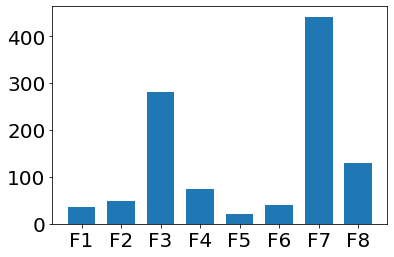

In [10]:
plt.rc('font', size=20)
X_Labels = ['F1','F2','F3','F4','F5','F6','F7','F8']
plt.bar(X_Labels, features[i], 0.7)#,  size=15)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
labels = pd.Categorical(Y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, 
                                            stratify = labels, random_state = 42)

In [20]:
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)

In [25]:
clf_RF = RandomForestClassifier(criterion='gini', max_features = 1, min_samples_leaf=1, min_samples_split=2, 
                                max_depth= 20, n_estimators= 300)
clf_RF.fit(train_data_scaled, y_train)

RandomForestClassifier(max_depth=20, max_features=1, n_estimators=300)

No. of Samples = 1200 /  k = 3 /  m = 1
ROC AUC = 1.000
F1 Score = 0.9980217606330366
Accuracy = 99.802 %


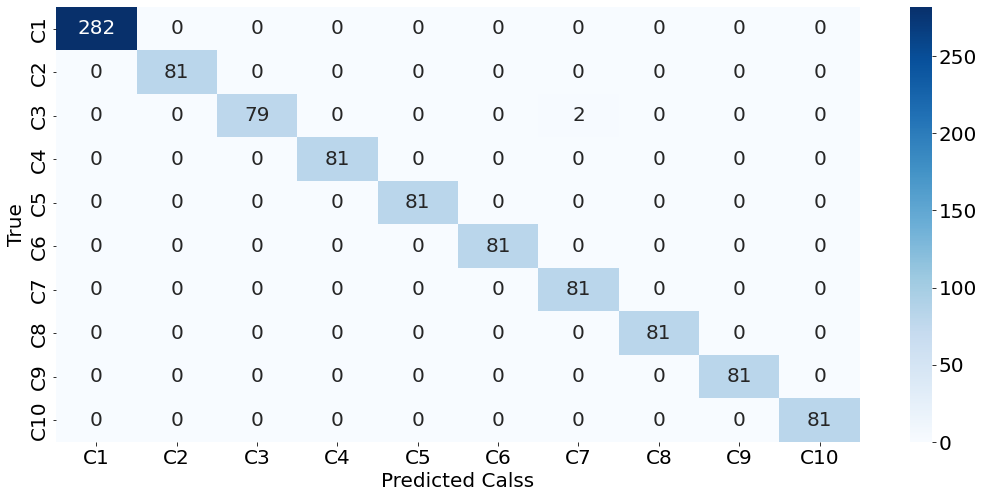

In [26]:
test_predictions = clf_RF.predict(test_data_scaled)
test_confu_matrix = confusion_matrix(y_test, test_predictions)
fault_type = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
plt.figure(1,figsize=(18,8))
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues")
plt.xlabel('Predicted Calss')
plt.ylabel('True Class')
plt.ylabel('True')
Accuracy = metrics.accuracy_score(y_test, test_predictions)
F1_score = metrics.f1_score(y_test, test_predictions, average='micro')
probs = clf_RF.predict_proba(test_data_scaled)
lr_auc = roc_auc_score(y_test, probs, multi_class='ovr')
print("No. of Samples =", num_samples, "/  k =", num_levels, "/  m =", m, )
print('ROC AUC = %.3f' % (lr_auc))
print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")